In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
import numpy as np
import pandas as pd 

In [4]:
import sys
sys.path.append('../../../')

In [5]:
import matplotlib.pyplot as plt 

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [7]:
from src.utils.dates import get_nyse_business_dates

In [8]:
from research.metrics import get_features_responses_correlation
from research.plots import plot_bin_summary_of_xy

In [9]:
from src.settings import Settings

In [10]:
from src.utils.io.read import PreprocessedDataReader

In [11]:
from src.preprocessing.base import FutureTicker

In [12]:
pdr = PreprocessedDataReader(Settings.historical.paths.PREPROCESSED_DATA_PATH)                    

In [13]:
dataset = pdr.read_dataset(ticker=FutureTicker.RBOB)

In [14]:
dataset.shape

(809, 81)

In [15]:
dataset.tail(2)

,tradeDate,Name,Commercial_NetPosition,CommercialLongPosition,CommercialShortPosition,ManagedMoney_NetPosition,ManagedMoney_LongPosition,ManagedMoney_ShortPosition,Commercial_NetPosition_change,prior_report_Commercial_NetPosition_change,...,prior_cumulative_5D_F2_Volume_change,next_prior_cumulative_5D_F2_Volume_change,prior_cumulative_5D_F1MinusF2_Volume_change,next_prior_cumulative_5D_F1MinusF2_Volume_change,F1_RolledPrice_change,next_F1_RolledPrice_change,F2_RolledPrice_change,next_F2_RolledPrice_change,F3_RolledPrice_change,next_F3_RolledPrice_change
807,2025-06-24,XB,-60881.0,128882.0,189763.0,36136.0,80365.0,44229.0,-3291.0,285.0,...,39197.0,-192059.0,-147137.0,100858.0,-18.62,3.5,-18.76,2.69,-18.46,2.1
808,2025-07-01,XB,-59728.0,120966.0,180694.0,30518.0,78539.0,48021.0,1153.0,-3291.0,...,-192059.0,NaN,100858.0,NaN,3.50,NaN,2.69,NaN,2.10,NaN


In [16]:
dataset['Commercial_NetPosition'].describe()

count       809.000000
mean    -103381.037083
std       24043.598793
min     -174838.000000
25%     -118477.000000
50%     -103276.000000
75%      -86819.000000
max      -29531.000000
Name: Commercial_NetPosition, dtype: float64

In [17]:
dataset['ManagedMoney_NetPosition'].describe()

count       809.000000
mean      62526.234858
std       19039.286552
min       11588.000000
25%       49026.000000
50%       61496.000000
75%       74912.000000
max      129000.000000
Name: ManagedMoney_NetPosition, dtype: float64

In [18]:
np.sum(dataset['ManagedMoney_LongPosition'] <= dataset['ManagedMoney_ShortPosition'])

np.int64(0)

In [19]:
dataset['tradeDate'] = pd.to_datetime(dataset['tradeDate']).dt.date

In [20]:
dataset.sort_values(by = 'tradeDate', ascending = True, inplace=True)

In [21]:
from research.model_selection.CombinatorialPurgedCV import CombinatorialPurgedCV
from research.model_selection.CombinatorialPurgedCV import cpcv_predict



In [22]:

from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


In [23]:
?CombinatorialPurgedCV

Init signature: CombinatorialPurgedCV(n_partitions: int, k: int, purge_amount: int)
Docstring:     
Combinatorial Purged Cross-Validatpr with Purging

This class identifies training and testing indicies that split the data into train/test sets. It also implements purging to avoid lookahead bias.
Init docstring:
Args:
:param n_partitions: the total number of partitions
:param k: the number of partitions to include in the test set
:param purge_amount: the number of indices to be purged between train/test sets
File:           ~/Documents/Projects/omroot_repos/COTAME/research/model_selection/CombinatorialPurgedCV.py
Type:           type
Subclasses:     

In [24]:
cv = CombinatorialPurgedCV(n_partitions=10,
                           k=2,
                           purge_amount=10)

In [25]:
import json

In [26]:
with open("rbob_cot_mm_forecast_selected_features_by_response.json", "r") as f:
    selected_features_by_response = json.load(f)

In [27]:
selected_features_by_response

{'forward_report_ManagedMoney_NetPosition_change': ['F3_RolledPrice_change',
  'prior_5D_F2_OI_change',
  'prior_5D_AGG_OI_change'],
 'forward_report_ManagedMoney_LongPosition_change': ['prior_report_ManagedMoney_ShortPosition_to_openinterest_change',
  'F3_RolledPrice_change',
  'prior_5D_F2_OI_change',
  'prior_5D_AGG_OI_change'],
 'forward_report_ManagedMoney_ShortPosition_change': ['prior_5D_F1_OI_change',
  'prior_5D_F1MinusF2_openinterest_change',
  'F3_RolledPrice_change',
  'prior_report_ManagedMoney_LongPosition_change',
  'prior_report_ManagedMoney_NetPosition_to_openinterest_change'],
 'forward_ManagedMoney_NetPosition_to_openinterest_change': ['prior_report_ManagedMoney_NetPosition_change',
  'prior_report_ManagedMoney_LongPosition_to_openinterest_change',
  'prior_cumulative_5D_F1MinusF2_Volume_change',
  'prior_5D_F1_OI_change',
  'prior_5D_F2_OI_change',
  'prior_5D_AGG_OI_change'],
 'forward_ManagedMoney_LongPosition_to_openinterest_change': ['F3_RolledPrice_rolling_20D

In [28]:
with open("rbob_cot_mm_forecast_selected_model_by_response.json", "r") as f:
    final_selected_model_and_parameters_per_response = json.load(f)

In [29]:
final_selected_model_and_parameters_per_response

{'forward_report_ManagedMoney_NetPosition_change': {'model_name': 'lasso',
  'params': {'alpha': 9.714586134002047}},
 'forward_report_ManagedMoney_LongPosition_change': {'model_name': 'lasso',
  'params': {'alpha': 9.714586134002047}},
 'forward_report_ManagedMoney_ShortPosition_change': {'model_name': 'extra',
  'params': {'n_estimators': 1200,
   'max_depth': 30,
   'min_samples_leaf': 1,
   'max_features': 'sqrt'}},
 'forward_ManagedMoney_NetPosition_to_openinterest_change': {'model_name': 'extra',
  'params': {'n_estimators': 1200,
   'max_depth': 21,
   'min_samples_leaf': 3,
   'max_features': 'sqrt'}},
 'forward_ManagedMoney_LongPosition_to_openinterest_change': {'model_name': 'ols',
  'params': {}},
 'forward_ManagedMoney_ShortPosition_to_openinterest_change': {'model_name': 'lasso',
  'params': {'alpha': 1.156732719914599}}}

In [30]:
from src.preprocessing.base import Winsorizer

In [31]:
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor, Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor


In [32]:
import shap

In [33]:
?shap.summary_plot

Signature:
shap.summary_plot(
    shap_values,
    features=None,
    feature_names=None,
    max_display=None,
    plot_type=None,
    color=None,
    axis_color='#333333',
    title=None,
    alpha=1,
    show=True,
    sort=True,
    color_bar=True,
    plot_size='auto',
    layered_violin_max_num_bins=20,
    class_names=None,
    class_inds=None,
    color_bar_label='Feature value',
    cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x1219c9510>,
    show_values_in_legend: 'bool' = False,
    use_log_scale: 'bool' = False,
    rng: 'np.random.Generator | None' = None,
)
Docstring:
Create a SHAP beeswarm plot, colored by feature values when they are provided.

Parameters
----------
shap_values : numpy.array
    For single output explanations this is a matrix of SHAP values (# samples x # features).
    For multi-output explanations this is a list of such matrices of SHAP values.

features : numpy.array or pandas.DataFrame or list
    Matrix of feature values (# samples x

Response name: forward_report_ManagedMoney_NetPosition_change


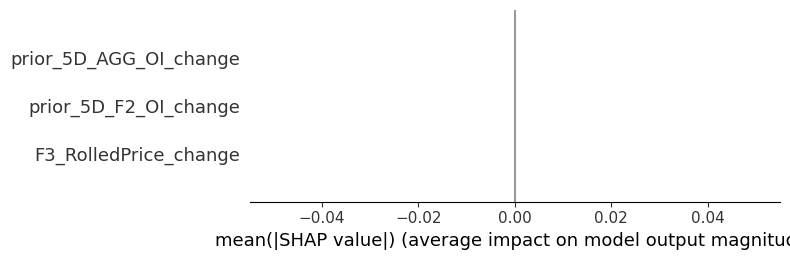

Response name: forward_report_ManagedMoney_LongPosition_change


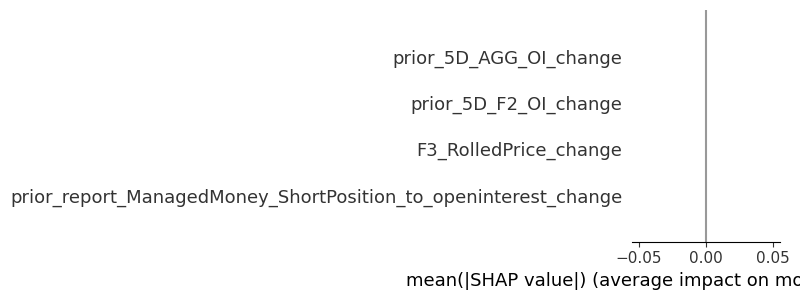

Response name: forward_report_ManagedMoney_ShortPosition_change


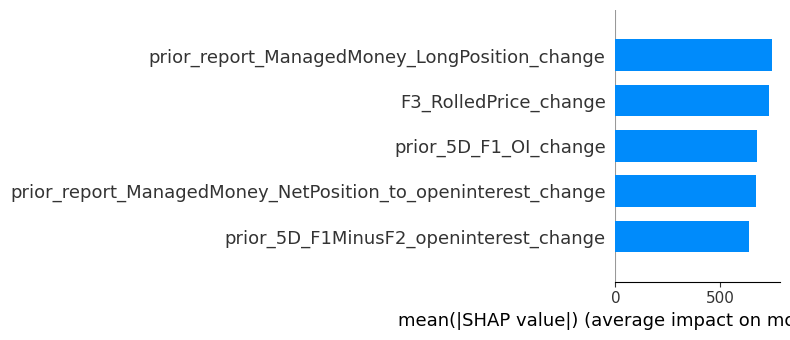

Response name: forward_ManagedMoney_NetPosition_to_openinterest_change


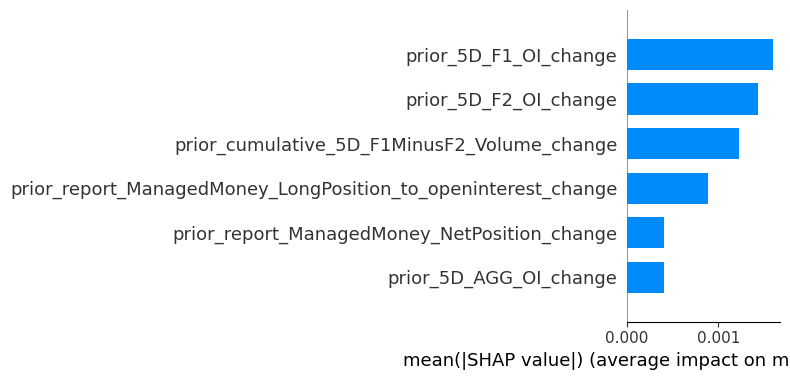

Response name: forward_ManagedMoney_LongPosition_to_openinterest_change


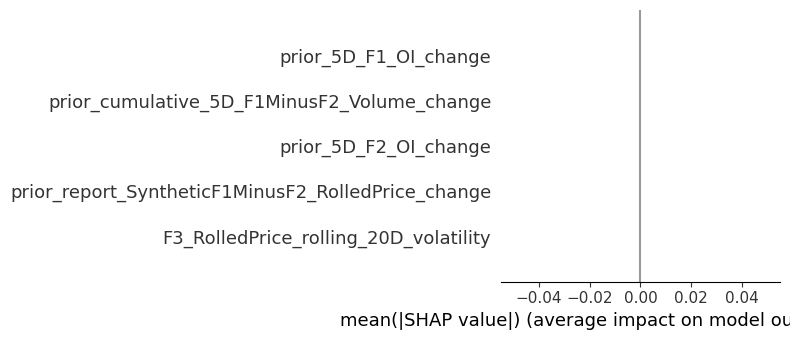

Response name: forward_ManagedMoney_ShortPosition_to_openinterest_change


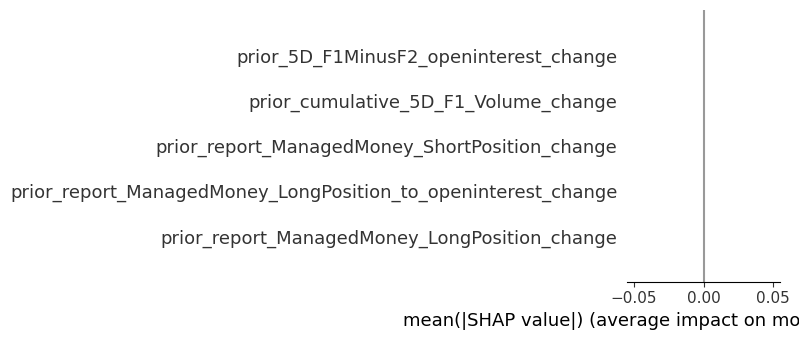

In [34]:
response_performance_map = {}
for response_name , model_info in final_selected_model_and_parameters_per_response.items():
    print(f'Response name: {response_name}')
    
    model_name = model_info['model_name']
    model_params = model_info['params']
    feature_names = selected_features_by_response[response_name]
    if model_name == "enet": 
        estimator = SGDRegressor(**model_params)
    elif model_name == "lasso": 
        estimator = Lasso(**model_params)
    elif model_name == "ols": 
        estimator = LinearRegression()
    elif model_name == "ridge": 
        estimator = Ridge(**model_params)
    elif  model_name == "rf": 
        estimator = RandomForestRegressor(**model_params)
    elif model_name == "extra":
        estimator = ExtraTreesRegressor(**model_params)
    elif model_name == "hgbm":
        estimator = HistGradientBoostingRegressor(**model_params)
        

    Xy = dataset[['tradeDate']+feature_names+[response_name]].dropna()
    Xy.reset_index(drop=True, inplace= True)

    estimator.fit(Xy[feature_names], Xy[response_name]) 
    X_sample = dataset[feature_names].sample(n=100)
    if model_name in ["rf" , "extra","hgbm" ]:
        explainer = shap.TreeExplainer(estimator)
        shap_values = explainer.shap_values(X_sample)
    elif model_name in ["enet" , "lasso","ols", "ridge" ]:
        explainer = shap.LinearExplainer(estimator, 
                                         dataset[feature_names].sample(50))
        shap_values = explainer.shap_values(dataset[feature_names].sample(100))
    shap.summary_plot(shap_values, 
                      X_sample, 
                      feature_names=feature_names, 
                      plot_type="bar")        



        
        